In [1]:
import tweepy as tw
import pandas as pd
from datetime import datetime
import json
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import pickle
import os

In [2]:
# Twitter API key and API secret
my_api_key = "GQ1kke9EehS4KOCMfHqDec2tf"
my_api_secret = "etiVr68pWASKCbJt6MEAjgKb95MTztzrShejHKEF1pbTZfbGLp"
access_token = '490367249-HnS3VpPZD1wkX6WkVm9QIS6AVR4Bydl3YKsbxu6i'
access_token_secret = '5QGkkQoT2aDWrWvjrfLvdw5WnnK3b7aDRStSN487Vl8IL'
# authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [3]:
print(tf.__version__)
print(tw.__version__)

2.8.0
4.10.0


In [4]:
# Get User by ID using username of Twitter Account
def get_userid(username):
    user_data = api.get_user(screen_name=username)
    user_id = user_data.id_str
    return user_id

In [5]:
# Clean Tweets
def clean_tweet(tweet):
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from", "rt"]
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [6]:
from typing import Text
# Crawling 1000 tweet data and convert to text
def get_tweets(tweeter_id, from_id = None, count = 1000):
    #Setup
    #l = StdOutListener()
    auth = tw.OAuthHandler(my_api_key, my_api_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)

    #Get tweets (status) from Twitter A
    if from_id == None:
        status = api.user_timeline(user_id = tweeter_id, count=count)
    else:
        status = api.user_timeline(user_id = tweeter_id, count=count, max_id = from_id)
        status.pop(0) #Remove duplicate first tweet, max_id not included.

    tweetlist = []
    last_id = 0

    #print("Cleaning tweets from :", status.user.screen_name, "id: ", twiter_id)
    for items in status:
        tweet = {}
        # tweet["id"] = items.id
        # tweet["user_id"] = tweeter_id
        # tweet["nickname"] = items.user.screen_name
        # tweet["realname"] = items.user.name
        # tweet["date"] = items.created_at
        tweet["text"] = items.text

        tweetlist.append(tweet)
        last_id = items.id
    
    # clean tweets to text
    a_List = []
    for x in range(1, len(tweetlist)):
        d_tweet = clean_tweet(tweetlist[x]['text'])
        if d_tweet not in a_List:
            a_List.append(d_tweet)

    text = " ".join(word for word in a_List)
    # print("Last ID: ", last_id, "\n")
    return text

In [7]:
# test Crawling Data
userid = get_userid("nadinelist")
list_tweet = get_tweets(userid)
print(list_tweet)

jadilah garam dan terang ya nak bagi orang orang sekitarmu bahagia djiwa bisa pakai dress yang kupakai saat b just posted photo 38 thank you atas kejutan ini love you blessed banyak helikopter lewat ya selamat idul fitri mohon maaf lahir dan bathin ya lebaran pertam djiwa kupukup selamat paskah tahun depan djiwa cari telur sendiri ya kalo sekarang kita siapin dech lebih tepatnya tadi pagi just posted photo hotel legrande suite bali djiwa ini namanya jalan jalan ya bersyukur sekali memiliki kalian berdua serta keluarga yang selalu mendukung s happy one month djiwa sarna menjagamu berarti menjaga ibu kembali terima kasih djiwa sarna djiwa bayi bali lahir di bali dipeluk oleh energi yang baik serta semesta sangat mendukung terima kasih keluarga just posted photo bali saat si cantik mengintip dunia hallo djiwa ketika hadir di dunia sapaan pertama djiwa terasa dari kelembutan hatinya untuk kami berdua keh asst koleksi outfitku atelier link di bio ya saat pem world wonder happy chinese new y

In [8]:
root_path = os.getcwd()
with open(root_path + '\datasets\dataset.json') as json_data:
    intents = json.load(json_data)
with open(root_path + '\datasets\\validation.json') as json_valid:
    validation = json.load(json_valid)

In [9]:
# Labelling data
def labelling_data(intents):
  inputs, targets = [], []
  labels = []
  response_for_every_label = {}

  for intent in intents['intents']:
      if intent['intent'] not in labels:
          labels.append(intent['intent'])
      if intent['intent'] not in response_for_every_label:
          response_for_every_label[intent['intent']] = []
          
      for text in intent['utterances']:
          inputs.append(clean_tweet(text))
          targets.append(intent['intent'])
          
      for response in intent['answers']:
          response_for_every_label[intent['intent']].append(response)
  return inputs, targets, response_for_every_label

In [10]:
inputs, targets, response_for_every_label = labelling_data(intents)
print(response_for_every_label)

{'hiking': ['Pariwisata Gunung'], 'swimming': ['Pariwisata Pantai'], 'eating': ['Pariwisata Kuliner']}


In [11]:
inputs, targets, response_for_every_label = labelling_data(intents)
validation_inputs, validation_targets, _ = labelling_data(validation)
all = inputs + validation_inputs

In [12]:
# Tokenizing data
vocab_size = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(all)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(inputs)
max_length = np.max([len(d) for d in training_sequences]) + 5
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_inputs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
# Saving tokenizing preprocessing
import pickle

# Pickle format
with open(root_path + '/datasets/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# JSON format
tokenizer_json = tokenizer.to_json()
with open(root_path + '/datasets/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [14]:
# Creating target/label tensor
def tensor_label(targets):
  word={}
  categorical_target=[]
  counter=0
  for trg in targets:
      if trg not in word:
          word[trg]=counter
          counter+=1
      categorical_target.append(word[trg])
      
      target_tensor = ku.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
      target_index_word =  dict((v,k) for k, v in word.items())
  return target_tensor, target_index_word

In [15]:
target_training, target_index_word = tensor_label(targets)
target_validation, _ = tensor_label(validation_targets)

In [16]:
# Recreate target index and response dictionary
responses = {}
for idx in target_index_word.keys():
  target_index_word[idx] = response_for_every_label[target_index_word[idx]][0]

In [17]:
with open(root_path + "/datasets/response.json", "w") as outfile: 
    json.dump(target_index_word, outfile)

In [18]:
# Tuning hyperparameters
total_words = len(tokenizer.word_index) + 1
embedding_dim = 512
epochs = 300
output_node = target_training.shape[1]

In [19]:
# Creating model
model = Sequential()
model.add(Embedding(total_words, embedding_dim))
model.add(Bidirectional(LSTM(512, return_sequences = True)))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(output_node, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         37888     
                                                                 
 bidirectional (Bidirectiona  (None, None, 1024)       4198400   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 1024)        0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         1311744   
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                        

In [20]:
# Setting Callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [21]:
# Training model
history = model.fit(training_padded,
                    target_training,
                    epochs=epochs,
                    callbacks = [callbacks],
                    validation_data = (validation_padded, target_validation))

Epoch 1/300
2/2 [==============================] - 12s 3s/step - loss: 2.7687 - accuracy: 0.3333 - val_loss: 2.7379 - val_accuracy: 0.2982
Epoch 2/300
2/2 [==============================] - 1s 714ms/step - loss: 2.7320 - accuracy: 0.2105 - val_loss: 2.6868 - val_accuracy: 0.2982
Epoch 3/300
2/2 [==============================] - 1s 601ms/step - loss: 2.6823 - accuracy: 0.2632 - val_loss: 2.6429 - val_accuracy: 0.2982
Epoch 4/300
2/2 [==============================] - 1s 595ms/step - loss: 2.6404 - accuracy: 0.1930 - val_loss: 2.6003 - val_accuracy: 0.3333
Epoch 5/300
2/2 [==============================] - 1s 590ms/step - loss: 2.5917 - accuracy: 0.3333 - val_loss: 2.5585 - val_accuracy: 0.3333
Epoch 6/300
2/2 [==============================] - 1s 593ms/step - loss: 2.5457 - accuracy: 0.4035 - val_loss: 2.5178 - val_accuracy: 0.3509
Epoch 7/300
2/2 [==============================] - 1s 591ms/step - loss: 2.5092 - accuracy: 0.2982 - val_loss: 2.4768 - val_accuracy: 0.3333
Epoch 8/300
2/2

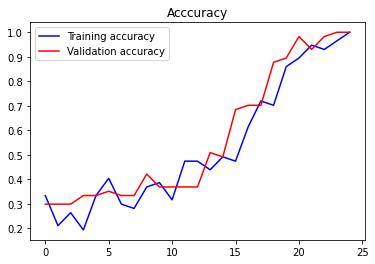

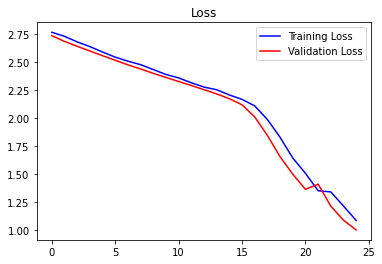

In [22]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Acccuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [23]:
# Inference
text = list_tweet
seq =  tokenizer.texts_to_sequences([text])
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predicted = np.argmax(model.predict(pad, verbose=0))
target_index_word[predicted].split("\n")

['Pariwisata Gunung']